In [1]:
import torch
import torchvision
import torchvision.models as models

In [10]:
class FireClassifierCAM(torch.nn.Module):
    def __init__(self, imagenet_init=True):
        super(FireClassifierCAM, self).__init__()

        self.backbone = models.densenet121(pretrained=imagenet_init).features
        self.g_avg_pool = torch.nn.AvgPool2d(kernel_size=7, stride=1)
        self.classifier = torch.nn.Linear(in_features=1024, out_features=1, bias=True)
        self.sigmoid = torch.nn.Sigmoid() 
        self._gradients = None
        
    def _activations_hook(self, grad):
        self._gradients = grad

    def forward(self, x):
        x = self.backbone(x) # conv. activations
        
        # keep gradients after last layer of the backbone
        if self.train and x.requires_grad:
            _ = x.register_hook(self._activations_hook)
        
        x = self.g_avg_pool(x)
        x = x.squeeze()
        x = self.classifier(x)
        
        x = self.sigmoid(x) #score (0-1)
        self._score = x # safe score tensor for backprop during gradCAM

        return x
    
    @property
    def gradients(self):
        # has to be called after output.backward()
        return self._gradients
    
    def activations(self, inputbatch):
        return self.backbone(inputbatch)
    
    def gradCAM(self, img_tensor):
        inputb = img_tensor.unsqueeze(dim=0)
        score = self(inputb)
        self._score.backward()
        
        pooled_gradients = torch.mean(self._gradients, dim=[0, 2, 3])
        activations = self.activations(inputb).detach()

        for i in range(1024):
            activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = heatmap.cpu().numpy()
        
        return heatmap

In [12]:
model = FireClassifierCAM()
model = model.to('cuda:0')
inputb = torch.ones((4,3,224,224)).to('cuda:0')
scores = model(inputb)

In [16]:
image_t = torch.ones((3,224,224)).to('cuda:0')
heatmap = model.gradCAM(image_t)

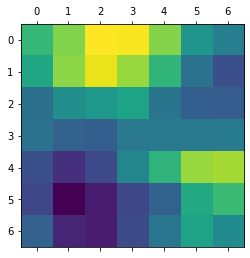

In [19]:
import matplotlib.pyplot as plt 
plt.matshow(heatmap)